# Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network

In this notebook we reproduce some results of the Super Resolution paper [1] in PyTorch.

[1] Ledig, C., Theis, L., Huszár, F., Caballero, J., Cunningham, A., Acosta, A., ... & Shi, W. (2017). Photo-realistic single image super-resolution using a generative adversarial network. In _Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4681-4690)_.

## Pre-processing: Loading datasets
In a first step we download all the required datasets.

In [ ]:
import requests

url_91 = ("https://drive.google.com/uc?export=download&id=1eVfd2Snh5bCl0ulMsRE4ker_p-o1M_lm")
url_set5 = ("https://drive.google.com/uc?export=download&id=1Cr4puJ1UpkXrGpzdpqZLNhZiZ2vaimoi")
url_set14 = ("https://drive.google.com/uc?export=download&id=1PQus6Glc3VsfVIywG6MAMBBBZVyyF_gB")


# Download data from Google drive and store as zip.
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


download_url(url_91, "./91.zip")
download_url(url_set5, "./set5.zip")
download_url(url_set14, "./set14.zip")

from zipfile import ZipFile

with ZipFile("91.zip", "r") as zipObj:
    zipObj.extractall("./train_data")

with ZipFile("set5.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("set14.zip", "r") as zipObj:
    zipObj.extractall("./test_data")


## Pre-processing: Prepare trainingset
We load in the training set using our custom loader. This loader also up/downscales the images.

In [1]:
from skimage import io
from os import listdir
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL


class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, upscale_factor, use_gpu=False):
        self.root_dir = root_dir
        self.upscale_factor = upscale_factor
        self.images = [
            f
            for f in listdir(self.root_dir)
            if f.endswith(".bmp") or f.endswith(".jpg")
        ]
        self.data = list()
        for image_name in self.images:
            self.data.append(self.get_data_from_image(image_name))

        if use_gpu:
            for i in range(len(self.data)):
                self.data[i] = (self.data[i][0].cuda(), self.data[i][1].cuda())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        return self.data[item]

    def get_data_from_image(self, image_name):
        image = io.imread(self.root_dir + "/" + image_name)

        h, w = len(image), len(image[0])
        cropped_h = h - (h % self.upscale_factor)
        cropped_w = w - (w % self.upscale_factor)

        target_transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.CenterCrop([cropped_h, cropped_w]),
                transforms.ToTensor(),
            ]
        )

        input_transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.CenterCrop([cropped_h, cropped_w]),
                transforms.Resize(
                    [
                        int(cropped_h // self.upscale_factor),
                        int(cropped_w // self.upscale_factor),
                    ],
                    PIL.Image.BICUBIC,
                ),
                transforms.ToTensor(),
            ]
        )

        target_image = target_transform(image)
        input_image = input_transform(image)

        return input_image, target_image

    def imshow_input(self, idx):
        img, _ = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_target(self, idx):
        _, img = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


The goal of this Deep Learning network is to upscale the image resolution. Therefore for our training set we first downscale the input. In the example below you see the input image for different upscale factors (9 and 3 respectively) whereas the target image is the image we want to retrieve in the end.

Input image (Up-scale factor 9): 


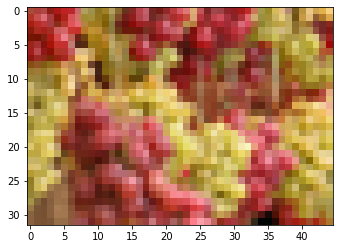

Input image (Up-scale factor 3): 


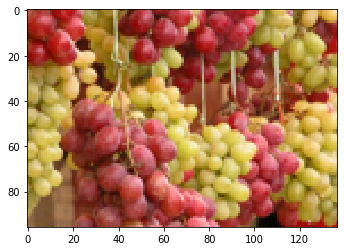

In [2]:
trainExample9 = SuperResolutionDataset("train_data/Set91", 9)
print("Input image (Up-scale factor 9): ")
trainExample9.imshow_input(0)

trainExample3 = SuperResolutionDataset("train_data/Set91", 3)
print("Input image (Up-scale factor 3): ")
trainExample3.imshow_input(0)

Target image: 


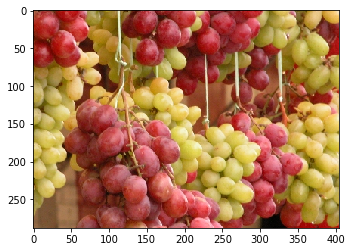

In [3]:
print("Target image: ")
trainExample9.imshow_target(0)

## Network Architecture

In [ ]:
import torch.nn as nn


class SuperResolutionNet(nn.Module):
    def __init__(self, r, l=3, activation=nn.Identity()):
        super().__init__()
        self.l = l
        self.r = r

        self.activation = activation

        self.conv1 = nn.Conv2d(3, 64, 5, padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, self.r * self.r * 3, 3, padding=1)

        self.deconvolution = nn.PixelShuffle(self.r)

        self.params = [self.conv1, self.conv2, self.conv3, self.conv4]

        self.l = l  # The number of hidden layers

    def forward(self, x):
        for i in range(self.l):
            x = self.activation(self.params[i](x))

        x = self.params[self.l](
            x
        )  # Don't use the activation on the last convolutional layer
        x = self.deconvolution(x)

        return x

## Training Network

In [ ]:
import math
import sys
from multiprocessing.spawn import freeze_support

import torch
from torch import optim, nn
from torchvision import transforms
import numpy as np

from SuperResolutionDataset import SuperResolutionDataset
from SuperResolutionNet import SuperResolutionNet


# Compute the PSNR using the MSE.
def mse_to_psnr(mse):
    return 10 * math.log10(1.0 / mse)


def main():
    use_gpu = torch.cuda.is_available()

    # Batch size.
    bs = 1

    # Upscale factor.
    r = 3

    # Amount of epochs.
    epochs = 20

    # Getting image data
    transform = transforms.Compose([transforms.ToTensor()])  # ,

    # Load the training data.
    training_set = SuperResolutionDataset("train_data/Set91", r, use_gpu=use_gpu)

    train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=bs, shuffle=True, num_workers=0
    )

    # Initialize the network.
    net = SuperResolutionNet(r, activation=nn.ReLU())

    # Decide to use GPU or not.
    if use_gpu:
        net = net.cuda()
        print("Running on gpu")

    # Set loss function and optimizer.
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(
        net.parameters(), lr=0.1, weight_decay=1e-6, momentum=0.9, nesterov=True
    )

    # Initialize loss.
    lowest_loss = (0, float("inf"))

    # Start training.
    for epoch in range(epochs):
        train_loss = []
        psnr = []

        # Train and propagate through network.
        net.train()
        for input, target in train_loader:

            optimizer.zero_grad()

            output = net(input)

            loss = loss_function(output, target)
            psnr.append(mse_to_psnr(loss.item()))

            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

        mean_train_loss = np.mean(train_loss)
        print(
            f"Epoch: {epoch: >3} Training Loss: {mean_train_loss:.6f} Mean PSNR: {np.mean(psnr):.3f}"
        )

        # Get the lowest loss.
        if mean_train_loss < lowest_loss[1]:
            lowest_loss = (epoch, mean_train_loss)

        # If we didn't improve, lets stop.
        if epoch > lowest_loss[0] + 100:
            print("No improvement for the last 100 epochs, so stopping training...")
            net.eval()
            torch.save(
                net,
                f"SuperResulutionNet_r-{r}_psnr-{int(round(np.mean(psnr) * 100))}__mse-{int(round(mean_train_loss * 10000))}",
            )
            break


if __name__ == "__main__":
    freeze_support()
    main()

## Evaluation

In [ ]:
import math

import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from os import listdir

from SuperResolutionDataset import SuperResolutionDataset
import numpy as np


def imshow(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


net = torch.load("saved_net")
r = net.r
print(f"r: {r}")

use_gpu = torch.cuda.is_available()

test_set_paths = ["test_data/" + f for f in listdir("test_data")]

for path in test_set_paths:
    psnr = []
    test_set = SuperResolutionDataset(path, r, use_gpu=use_gpu)

    train_loader = torch.utils.data.DataLoader(
        test_set, batch_size=1, shuffle=True, num_workers=0
    )

    for input, target in iter(train_loader):
        if use_gpu:
            input = input.cuda()
            target = target.cuda()

        if input.size()[1] == 1:
            input = input.repeat(1, 3, 1, 1)

        output = net(input)

        if use_gpu:
            input = input.cpu()
            output = output.cpu()
            target = target.cpu()

        bicubic = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(
                    [int(r * input.size()[2]), int(r * input.size()[3])],
                    PIL.Image.BICUBIC,
                ),
                transforms.ToTensor(),
            ]
        )
        bicubic_upscaled = bicubic(input[0])

        nearest_neighbour = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(
                    [int(r * input.size()[2]), int(r * input.size()[3])],
                    PIL.Image.NEAREST,
                ),
                transforms.ToTensor(),
            ]
        )

        input = nearest_neighbour(input[0])
        output = torch.clamp(output.detach(), 0, 1)

        if target.size()[1] == 1:
            target = target.repeat(1, 3, 1, 1)

        mse_loss = nn.MSELoss()
        psnr.append(10 * math.log10(1.0 / mse_loss(output, target).item()))

        # images = [input, target[0], output.detach()[0], bicubic_upscaled]

        # imshow(torchvision.utils.make_grid(images))
    print(f"{path} psnr: {np.mean(psnr)}")

# plt.show()
